<a href="https://colab.research.google.com/github/AnandVP123/q1/blob/main/Assignmentee20d064oe21d019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install Wandb


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import wandb

# load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_type = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

proj_name='CS6910_ass1'





Sample Images for each Class :


wandb: Currently logged in as: oe21d019 (use `wandb login --relogin` to force relogin)


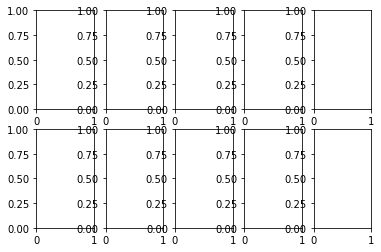

In [ ]:


print("Sample Images for each Class :")
class_list=list()
wandb.init(project=proj_name)
for i in range(10):
  plt.subplot(2,5,i+1)
  for j in range(len(y_train)):
    if y_train[j] == i :
        wandb.log({"img": [wandb.Image(x_train[j], caption=class_type[y_train[j]])]})
        class_list.append(class_type[y_train[j]])
        break    

In [ ]:
def activate(x,activation):                                                           # Hidden layer activation function                                  

  if activation == "sigmoid":
    return 1/(1 + np.exp(-x))

  elif activation == "tanh": 
    return np.tanh(x) 

  elif activation == "relu": 
    return x * (x > 0) 

def softmax(x):                                                                       # Output activation function
    return np.exp(x) / np.sum(np.exp(x)) 

def feed_forward(x,parameters,sizes,activation):                                # feed-forward data through the network to estimate output
  
  H = {}
  A={}
  H[0] = x
 
  for i in range(1,len(sizes)-1):
    W = parameters["W"+str(i)]
    b = parameters["b"+str(i)]
    A[i] = np.dot(W,H[i-1])+b
    H[i] = activate(A[i],activation)
    
  W = parameters["W"+str(len(sizes)-1)]
  b = parameters["b"+str(len(sizes)-1)]
  A[len(sizes)-1] = np.dot(W,H[len(sizes)-2])+b
  #print("A:",A[2],"H:",H[3],len(sizes))

  y_hat = softmax(A[len(sizes)-1])
  #print(y_hat)
  
  return y_hat,A,H

def loss_compute(y,y_hat,parameters,loss_type,reg,sizes):                                               # function to compute the loss/error (both squared error and cross entropy)

  if (loss_type == "squared_error"):
    error = np.sum((y-y_hat)**2)/(2*len(y))
  elif (loss_type == "cross_entropy") :
    error = -1*np.sum(np.multiply(y,np.log(y_hat)))/len(y)
		
  reg_error = 0.0                                                                        # account for regularization to avoid overfit of data - L2 norm regularization
  for i in range(1,len(sizes)) :
    reg_error = reg_error + (reg/2)*(np.sum(np.square(parameters["W"+str(i)]))) 
  error = error + reg_error

  return error

In [ ]:
def derivative(x,activation):                                                            # function to compute the derivative of hidden layer activation fn

  if activation == "sigmoid":
    return activate(x,"sigmoid")*(1-activate(x,"sigmoid"))
  elif activation == "tanh": 
    return 1. - x * x 
  elif activation == "relu": 
    return 1. * (x > 0)

def grad_init(sizes):
  
  grads={}
  layers=len(sizes)
  for i in range(1,layers):
    grads["dW" + str(i)] = np.zeros((sizes[i], sizes[i-1]))
    grads["db" + str(i)] = np.zeros((sizes[i],1))

  return grads  


def back_prop(X,Y,Y_hat,prev_grad,A,H,parameters,sizes,loss_type,activation,reg) :               # back-propogation rule to compute the gradients of activation, pre-activation and parameters
  
  new_grad = {}
  grads = {}
  # grads = {"dH0":np.zeros((input_size,1)),"dA0":np.zeros((input_size,1))}
  for i in range(1,len(sizes)):
    grads["dW" + str(i)] = np.zeros((sizes[i], sizes[i-1]))
    grads["db" + str(i)] = np.zeros((sizes[i],1))
    grads["dA" + str(i)] = np.zeros((sizes[i],1))
    grads["dH" + str(i)] = np.zeros((sizes[i],1))

  if loss_type == "squared_error":
    grads["dH"+str(len(sizes)-1)] = (Y_hat-Y) 
    grads["dA"+str(len(sizes)-1)] = (Y_hat - Y)*Y_hat - Y_hat*(np.dot(np.transpose((Y_hat-Y)), Y_hat))

  elif loss_type=="cross_entropy" :
    grads["dH"+str(len(sizes)-1)] = -(Y/Y_hat) 
    grads["dA"+str(len(sizes)-1)] = -(Y-Y_hat)

  for i in range(len(sizes)-1, 0, -1):
    grads["dW" + str(i)] = np.dot(grads["dA" + str(i)], np.transpose(H[i-1]))
    grads["db" + str(i)] = grads["dA" + str(i)] 
    if i>1 :
      grads["dH" + str(i-1)] = np.dot(np.transpose(parameters["W" + str(i)]), grads["dA" + str(i)])
      grads["dA" + str(i-1)] = np.multiply((grads["dH" + str(i-1)]),derivative(A[i-1],activation))
    
  for i in range(1,len(sizes)):
    new_grad["dW" + str(i)] = grads["dW" + str(i)] + prev_grad["dW" + str(i)]
    new_grad["db" + str(i)] = grads["db" + str(i)] + prev_grad["db" + str(i)]
    
  return new_grad  

In [ ]:
# Initializations

# Data
X_train = np.array(x_train.reshape(x_train.shape[0], 784,1))         # reshape 2-D data to 1-D
X_test = np.array(x_test.reshape(x_test.shape[0], 784,1))            # reshape 2-D data to 1-D

def normalize_data(x):                                               # normalize input data
  x_norm = x.astype('float32')
  x_norm = x_norm / 255.0  
  return x_norm 

X_train = normalize_data(X_train)
X_val = X_train[-6000:]                                             # validation set input
X_train = X_train[0:54000]                                          # training set input
X_test = normalize_data(X_test)                                     # test set input


Y_train = np.zeros([len(y_train),10,1])
Y_test = np.zeros([len(y_test),10,1])

for i in range(len(y_train)):                                        # convert y from just a class number to an indicator vector (10x1)
  y = np.zeros([10, 1])
  y[y_train[i]] = 1.0
  Y_train[i] = y

Y_val = Y_train[-6000:]                                              # validation set output
Y_train = Y_train[0:54000]                                           # training set output

for i in range(len(y_test)):                                         # convert y from just a class number to an indicator vector (10x1)
  y = np.zeros([10, 1])
  y[y_test[i]] = 1.0
  Y_test[i] = y                                                      # test set output

In [ ]:
def network_init(sizes,w_init):                            # function to initialize weights and biases
  parameters = {}
  for i in range(1, len(sizes)):
    if w_init == "xavier" :
      parameters["W" + str(i)] = np.random.randn(sizes[i], sizes[i-1])*np.sqrt(2./(sizes[i] + sizes[i-1]))
      parameters["b" + str(i)] = np.zeros((sizes[i],1))
    elif w_init == "random" :
      parameters["W" + str(i)] = 0.01*np.random.randn(sizes[i], sizes[i-1])
      parameters["b" + str(i)] = 0.01*np.random.randn(sizes[i],1)

  return parameters  

def update_init(sizes) :                                  # function to initialize update dictionary that changes the weights and biases
  update = {}
  for i in range(1,len(sizes)):
   update["W"+str(i)] = np.zeros((sizes[i],sizes[i-1]))
   update["b"+str(i)] = np.zeros((sizes[i],1))

  return update

In [ ]:
def val_loss(y,y_hat,loss_type):                                # function to compute the loss/error (both squared error and cross entropy)
  l = 0
  if (loss_type == "squared_error"):
    l = np.sum((y-y_hat)**2)/(2*len(y))
  elif (loss_type == "cross_entropy") :
    l = -1*np.sum(np.multiply(y,np.log(y_hat)))/len(y)
  return l 

def calcAccLoss(parameters,xArr,yArr,sizes,loss_type,activation,type="val",regu=None):          #function to calculate accuracy and total loss of a model
  acc=0.0
  lossVal=0.0
  for x,y in zip(xArr,yArr):
    y_hat= feed_forward(x,parameters,sizes,activation)[0]
    if y_hat.argmax()==y.argmax():
      acc+=1
    if type=="val":
      lossVal+=val_loss(y,y_hat,loss_type)
    elif type=="trng":
      lossVal+=loss_compute(y,y_hat,parameters,loss_type,regu,sizes)
  acc=acc/len(xArr)
  return (acc,lossVal)

In [ ]:
#momentum Gradient descent
def momentum_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=False) :

   steps=0                                                                                      #used to count number of updates to parameters
   parameters = network_init(sizes,w_init)
   update = update_init(sizes)
   gamma = 0.9
   for n in range(n_epoch):

     for j in range(0, X_train.shape[0], minibatch_size):                                       #minibatch division 
       X_mini = X_train[j:j + minibatch_size]
       Y_mini = Y_train[j:j + minibatch_size]
       grads = grad_init(sizes)

       for x,y in zip(X_mini,Y_mini):
         y_hat,A,H = feed_forward(x,parameters,sizes,activation)                                 
         grads = back_prop(x,y,y_hat,grads,A,H,parameters,sizes,loss_type,activation,reg)

       for i in range(1,len(sizes)) :                                                           #updating the parameters
         update["W"+str(i)] = gamma*update["W"+str(i)] + lr*grads["dW"+str(i)]                  
         update["b"+str(i)] = gamma*update["b"+str(i)] + lr*grads["db"+str(i)]
         parameters["W"+str(i)] = (1-lr*reg)*parameters["W"+str(i)] - update["W"+str(i)]
         parameters["b"+str(i)] = (1-lr*reg)*parameters["b"+str(i)] - update["b"+str(i)]
       
       steps=steps+1
       if steps==10000:                                                                         #log every 10000 updates
        acc,lossTot=calcAccLoss(parameters,X_train,Y_train,sizes,loss_type,activation,type="trng",regu=reg)          #calculating accuracy and loss
        accVal,lossTotVal=calcAccLoss(parameters,X_val,Y_val,sizes,loss_type,activation)

        wandb.log({"Accuracy":acc,"Loss":lossTot,"Accuracy_val":accVal,"Loss_val":lossTotVal,"Epoch":n,"n_datatrain":j + minibatch_size+n*54000}) #logging
        steps=0
  
   return parameters        

#Nesterov acceleracted GD
def nesterov_accelerated_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=False) :
  steps=0
  parameters = network_init(sizes,w_init)
  update = update_init(sizes)
  gamma = 0.9
  for n in range(n_epoch):

    for j in range(0, X_train.shape[0], minibatch_size):
      X_mini = X_train[j:j + minibatch_size]
      Y_mini = Y_train[j:j + minibatch_size]
      

      grads = grad_init(sizes)
      for i in range(1,len(sizes)):                                                       #perform update before back propogation
        update["W"+str(i)] = gamma*update["W"+str(i)]
        update["b"+str(i)] = gamma*update["b"+str(i)]
        parameters["W"+str(i)] = (1-lr*reg)*parameters["W"+str(i)] - update["W"+str(i)]
        parameters["b"+str(i)] = (1-lr*reg)*parameters["b"+str(i)] - update["b"+str(i)]        

      for x,y in zip(X_mini,Y_mini):
        y_hat,A,H = feed_forward(x,parameters,sizes,activation)
        grads = back_prop(x,y,y_hat,grads,A,H,parameters,sizes,loss_type,activation,reg)
        
      for k in range(1,len(sizes)) :
        update["W"+str(k)] = gamma*update["W"+str(k)] + lr*grads["dW"+str(k)]
        update["b"+str(k)] = gamma*update["b"+str(k)] + lr*grads["db"+str(k)]
        parameters["W"+str(k)] = (1-lr*reg)*parameters["W"+str(k)] - update["W"+str(k)]
        parameters["b"+str(k)] = (1-lr*reg)*parameters["b"+str(k)] - update["b"+str(k)]
      steps=steps+1
      if steps==10000:
        if log:
          acc,lossTot=calcAccLoss(parameters,X_train,Y_train,sizes,loss_type,activation,type="trng",regu=reg)     
          accVal,lossTotVal=calcAccLoss(parameters,X_val,Y_val,sizes,loss_type,activation)

          wandb.log({"Accuracy":acc,"Loss":lossTot,"Accuracy_val":accVal,"Loss_val":lossTotVal,"Epoch":n,"n_datatrain":j + minibatch_size+n*54000})
        steps=0   
    
  return parameters

#stochastic GD
def stochastic_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=False) :

  steps=0
  parameters = network_init(sizes,w_init)
  update = update_init(sizes)
  gamma = 0.9
  for n in range(n_epoch):

    for j in range(0, X_train.shape[0], minibatch_size):                                        #minibatch division
      X_mini = X_train[j:j + minibatch_size]
      Y_mini = Y_train[j:j + minibatch_size]
      
      grads = grad_init(sizes)
      for x,y in zip(X_mini,Y_mini):
        y_hat,A,H = feed_forward(x,parameters,sizes,activation)
        grads = back_prop(x,y,y_hat,grads,A,H,parameters,sizes,loss_type,activation,reg)
        
      for i in range(1,len(sizes)-1) :                                                          #updating the parameters
        parameters["W"+str(i)] = (1-lr*reg)*parameters["W"+str(i)] - lr*grads["dW"+str(i)]
        parameters["b"+str(i)] = (1-lr*reg)*parameters["b"+str(i)] - lr*grads["db"+str(i)]
      steps=steps+1
      if steps==10000:
        if log:
          acc,lossTot=calcAccLoss(parameters,X_train,Y_train,sizes,loss_type,activation,type="trng",regu=reg)     
          accVal,lossTotVal=calcAccLoss(parameters,X_val,Y_val,sizes,loss_type,activation)

          wandb.log({"Accuracy":acc,"Loss":lossTot,"Accuracy_val":accVal,"Loss_val":lossTotVal,"Epoch":n,"n_datatrain":j + minibatch_size+n*54000})
        steps=0   

  return parameters        

#rmsprop GD
def rmsprop_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=False) :
  
  steps=0
  parameters = network_init(sizes,w_init)
  update = update_init(sizes)
  v = update_init(sizes)

  betal = 0.99 #check this
  eps = 1e-8

  for n in range(n_epoch):

    for j in range(0, X_train.shape[0], minibatch_size):
      X_mini = X_train[j:j + minibatch_size]
      Y_mini = Y_train[j:j + minibatch_size]
      
      grads = grad_init(sizes)
      for x,y in zip(X_mini,Y_mini):
        y_hat,A,H = feed_forward(x,parameters,sizes,activation)
        grads = back_prop(x,y,y_hat,grads,A,H,parameters,sizes,loss_type,activation,reg)

      for i in range(1,len(sizes)-1) :                                                                   #updating the parameters
        v["W"+str(i)] = betal*v["W"+str(i)] + (1-betal)*grads["dW"+str(i)]**2                            #v_w update  
        v["b"+str(i)] = betal*v["b"+str(i)] + (1-betal)*grads["db"+str(i)]**2                            #v_b update

        update["W"+str(i)]=lr*np.multiply(np.reciprocal(np.sqrt(v["W"+str(i)]+eps)),grads["dW"+str(i)])                 
        update["b"+str(i)]=lr*np.multiply(np.reciprocal(np.sqrt(v["b"+str(i)]+eps)),grads["db"+str(i)])
        
        parameters["W"+str(i)] = (1-lr*reg)*parameters["W"+str(i)] - update["W"+str(i)]
        parameters["b"+str(i)] = (1-lr*reg)*parameters["b"+str(i)] - update["b"+str(i)]
      steps=steps+1
      if steps==10000:
        if log:
          acc,lossTot=calcAccLoss(parameters,X_train,Y_train,sizes,loss_type,activation,type="trng",regu=reg)     
          accVal,lossTotVal=calcAccLoss(parameters,X_val,Y_val,sizes,loss_type,activation)

          wandb.log({"Accuracy":acc,"Loss":lossTot,"Accuracy_val":accVal,"Loss_val":lossTotVal,"Epoch":n,"n_datatrain":j + minibatch_size+n*54000})
        steps=0   

  return parameters          

#Adam GD
def adam_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=False) :
  steps=0
  parameters = network_init(sizes,w_init)
  update = update_init(sizes)
  m = update_init(sizes)
  v = update_init(sizes)

  beta1 = 0.9
  beta2 = 0.999
  eps = 1e-8
  for n in range(n_epoch):

    for j in range(0, X_train.shape[0], minibatch_size):
      X_mini = X_train[j:j + minibatch_size]
      Y_mini = Y_train[j:j + minibatch_size]
      
      grads = grad_init(sizes)                                          
      for x,y in zip(X_mini,Y_mini):
        y_hat,A,H = feed_forward(x,parameters,sizes,activation)
        grads = back_prop(x,y,y_hat,grads,A,H,parameters,sizes,loss_type,activation,reg)
        
      for i in range(1,len(sizes)-1) :                                                    #updating the parameters
        m["W"+str(i)] = beta1*m["W"+str(i)] + (1-beta1)*grads["dW"+str(i)]                #m_w update
        m["b"+str(i)] = beta1*m["b"+str(i)] + (1-beta1)*grads["db"+str(i)]                #m_b update

        v["W"+str(i)] = beta2*v["W"+str(i)] + (1-beta2)*grads["dW"+str(i)]**2             #v_w update    
        v["b"+str(i)] = beta2*v["b"+str(i)] + (1-beta2)*grads["db"+str(i)]**2             #v_b update

        #cumulative average
        m_w_hat = m["W"+str(i)]/(1-np.power(beta1,n+1))                                   
        m_b_hat = m["b"+str(i)]/(1-np.power(beta1,n+1))
        v_w_hat = v["W"+str(i)]/(1-np.power(beta2,n+1))
        v_b_hat = v["b"+str(i)]/(1-np.power(beta2,n+1))


        update["W"+str(i)]=lr*np.multiply(np.reciprocal(np.sqrt(v_w_hat+eps)),m_w_hat)
        update["b"+str(i)]=lr*np.multiply(np.reciprocal(np.sqrt(v_b_hat+eps)),m_b_hat)

        parameters["W"+str(i)] = (1-lr*reg)*parameters["W"+str(i)] - update["W"+str(i)]
        parameters["b"+str(i)] = (1-lr*reg)*parameters["b"+str(i)] - update["b"+str(i)]
      
    
      steps=steps+1
      if steps==10000:
        if log:
          acc,lossTot=calcAccLoss(parameters,X_train,Y_train,sizes,loss_type,activation,type="trng",regu=reg)     
          accVal,lossTotVal=calcAccLoss(parameters,X_val,Y_val,sizes,loss_type,activation)

          wandb.log({"Accuracy":acc,"Loss":lossTot,"Accuracy_val":accVal,"Loss_val":lossTotVal,"Epoch":n,"n_datatrain":j + minibatch_size+n*54000})
        steps=0     

  return parameters   


#Nadam GD
def nadam_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=False) :
  steps=0
  parameters = network_init(sizes,w_init)
  update = update_init(sizes)
  m = update_init(sizes)
  v = update_init(sizes)

  beta1 = 0.9
  beta2 = 0.999
  eps = 1e-8

  for n in range(n_epoch):

    for j in range(0, X_train.shape[0], minibatch_size):
      X_mini = X_train[j:j + minibatch_size]
      Y_mini = Y_train[j:j + minibatch_size]
      grads = grad_init(sizes)

      for x,y in zip(X_mini,Y_mini):
        y_hat,A,H = feed_forward(x,parameters,sizes,activation)
        grads = back_prop(x,y,y_hat,grads,A,H,parameters,sizes,loss_type,activation,reg)

      for i in range(1,len(sizes)-1) :                                                    #updating the parameters
        m["W"+str(i)] = beta1*m["W"+str(i)] + (1-beta1)*grads["dW"+str(i)]                #m_w update
        m["b"+str(i)] = beta1*m["b"+str(i)] + (1-beta1)*grads["db"+str(i)]                #m_b update

        v["W"+str(i)] = beta2*v["W"+str(i)] + (1-beta2)*grads["dW"+str(i)]**2             #v_w update    
        v["b"+str(i)] = beta2*v["b"+str(i)] + (1-beta2)*grads["db"+str(i)]**2             #v_b update

        #cumulative average
        m_w_hat = m["W"+str(i)]/(1-np.power(beta1,n+1))                                   
        m_b_hat = m["b"+str(i)]/(1-np.power(beta1,n+1))
        v_w_hat = v["W"+str(i)]/(1-np.power(beta2,n+1))
        v_b_hat = v["b"+str(i)]/(1-np.power(beta2,n+1))


        update["W"+str(i)]=lr*np.multiply(np.reciprocal(np.sqrt(v_w_hat+eps)),(beta1*m_w_hat+(1-beta1)*grads["dW"+str(i)]))*(1/(1-np.power(beta1,n+1)))
        update["b"+str(i)]=lr*np.multiply(np.reciprocal(np.sqrt(v_b_hat+eps)),(beta1*m_b_hat+(1-beta1)*grads["db"+str(i)]))*(1/(1-np.power(beta1,n+1)))

        parameters["W"+str(i)] = (1-lr*reg)*parameters["W"+str(i)] - update["W"+str(i)]
        parameters["b"+str(i)] = (1-lr*reg)*parameters["b"+str(i)] - update["b"+str(i)]
      steps=steps+1
      if steps==10000:
        if log:
          acc,lossTot=calcAccLoss(parameters,X_train,Y_train,sizes,loss_type,activation,type="trng",regu=reg)     
          accVal,lossTotVal=calcAccLoss(parameters,X_val,Y_val,sizes,loss_type,activation)

          wandb.log({"Accuracy":acc,"Loss":lossTot,"Accuracy_val":accVal,"Loss_val":lossTotVal,"Epoch":n,"n_datatrain":j + minibatch_size+n*54000})
        steps=0   

  return parameters   

In [ ]:
#function to select optimizer
def do_GD(X_train,Y_train,optimizer,activation,hl_size,input_size,output_size,n_epoch,lr,reg,w_init,loss_type,minibatch_size=1,logging=False):
  sizes = hl_size.copy() 
  sizes.insert(0,input_size)
  sizes.append(output_size)

  if optimizer=="sgd":
    return(stochastic_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="momentum":
    return(momentum_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="nesterov":
    return(nesterov_accelerated_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="rmsprop":
    return(rmsprop_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="adam":
    return(adam_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="nadam":
    return(nadam_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))

In [ ]:
#training function to sweep with wandb
def train():

  hyperparameter_defaults=dict(
      input_size = 784,                                       
      output_size = 10,                                                    
      n_epoch = 5,                                            
      n_hiddenlayer = 3,                               
      hl= [64,64,64],
      reg = 0.0005,      
      lr = 1e-3,                                              
      optimizer = "momentum",                      
      batch_size = 64,       
      initialization = "xavier",      
      loss_type = "cross_entropy" 
      
  )

  wandb.init(config=hyperparameter_defaults)

  config=wandb.config
  output_size=10
  input_size = 784                                      
  config.hl=[config.hl_size for i in range(config.n_hiddenlayer)]   #hidden layer sizes array creation
  parameters=do_GD(X_train,Y_train,config.optimizer,config.activation,config.hl,config.input_size,config.output_size,config.n_epoch,config.lr,config.reg,config.initialization,config.loss_type,config.batch_size,logging=True)

In [ ]:
def sweeper(sweep_config,proj_name):
  sweep_id=wandb.sweep(sweep_config,project=proj_name)
  wandb.agent(sweep_id,train,project=proj_name)

In [ ]:
#sweep dictionary
sweep_config={
    'method':'bayes',
    'metric':{
        'name':'accuracy',
        'goal':'maximize'},

}

parameters_dict={
    'optimizer':{
        'values':['nadam','sgd', 'momentum', 'nesterov', 'rmsprop', 'adam']
    },
    'lr':{
        'values':[1e-3,1e-5]
    },
    'reg':{
        'values':[5e-4,0,5e-1]
    },
    'n_hiddenlayer':{
        'values':[3,4,5]
    },
    'hl_size':{
      'values':[128,32,64]  
    },
    'batch_size':{
        'values':[64,32,128]
    },
    'loss_type':{
        'values':['cross_entropy','squared_error']
    },
    'initialization':{
        'values':['xavier','random']
    },
    'activation':{
        'values':['relu','sigmoid','tanh']
    },
    'n_epoch':{
        'values':[5]
    }
}

sweep_config['parameters']=parameters_dict

In [ ]:
sweep_id=wandb.sweep(sweep_config,project=proj_name)

Create sweep with ID: ag4ietor
Sweep URL: https://wandb.ai/oe21d019/CS6910_ass1/sweeps/ag4ietor


In [ ]:
sweeper(sweep_config,proj_name)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 7hgrv867
Sweep URL: https://wandb.ai/oe21d019/CS6910_ass1/sweeps/7hgrv867


wandb: Agent Starting Run: z8i9ig1x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


In [ ]:
#confusion matrix and accuracy for test values
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

hyperparameter_final=dict(
    input_size = 784,                                       
    output_size = 10,                                                    
    n_epoch = 5,                                            
    n_hiddenlayer = 3,                               
    hl= [128,128,128],
    reg = 0,      
    lr = 1e-5,                                              
    optimizer = "nadam",                      
    batch_size = 128,       
    initialization = "xavier",      
    loss_type = "cross_entropy",
    activation="relu" 
    
)

wandb.init(config=hyperparameter_final,project=proj_name)
config=wandb.config
parameters_test=do_GD(X_train,Y_train,config.optimizer,config.activation,config.hl,config.input_size,config.output_size,config.n_epoch,config.lr,config.reg,config.initialization,config.loss_type,config.batch_size,logging=False)

sizes = config.hl.copy() 
sizes.insert(0,config.input_size)
sizes.append(config.output_size)

Y_prob=np.empty(np.shape(y_test))
#finding y predicted
for i,x in enumerate(X_test):
  Y_prob[i]= (feed_forward(x,parameters_test,sizes,config.activation)[0]).argmax()

accuracy=calcAccLoss(parameters_test,X_test,Y_test,sizes,None,config.activation)[0]

wandb.log({"conf_mat" : wandb.plot.confusion_matrix(preds=Y_prob, y_true=y_test,class_names=class_list),"Test Accuracy": accuracy })